# Visualize donut deconvolution performance (Fig S8 - 13)

In [1]:
import itertools
import warnings
import torch
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.metrics import roc_auc_score, average_precision_score
from smoother import SpatialWeightMatrix, SpatialLoss
from smoother.models.deconv import NNLS, NuSVR, DWLS, LogNormReg
from smoother.visualization import *
import matplotlib
import matplotlib.pyplot as plt
from plotnine import *
from plotnine_prism import *

In [2]:
DATA_FOLDER = "/Users/jysumac/Projects/Smoother_paper/data/synthetic_deconv/donut/"
RES_FOLDER = "/Users/jysumac/Projects/Smoother_paper/results/synthetic_deconv/donut/"

pal = ['#E64B35', '#4DBBD5', '#00A087', '#3C5488', '#F39B7F', '#8491B4', '#91D1C2', '#DC0000', '#7E6148', '#B09C85']
dict_markers = {'20':'Top 20 (n=283)', '50':'Top 50 (n=656)', '0':'All specific (n=2693)', 'c':'CARD-selected (n=7972)'}

from plotnine.scales.scale import scale_discrete
class scale_fill_npg(scale_discrete):
    """GGSCI-NPG fill scale
    Args:
        palette: The fill palette name
    """

    _aesthetics = ["fill"]
    na_value = "#7F7F7F"

    def __init__(self, palette="colors", **kwargs):
        """Construct"""
        self.palette = lambda n: pal[:n]
        scale_discrete.__init__(self, **kwargs)

## Load and process deconv results

In [3]:
def load_deconv_results(data_dir, res_dir, num_exp = 10):
    # load true cell type abundances
    ab_true = pd.read_csv(data_dir + f"/celltype_abundances.csv", header = 0, index_col = 0)
    celltypes = ab_true.columns

    # calculate proportion
    p_true = pd.DataFrame(
        ab_true.to_numpy() / (ab_true.to_numpy().sum(axis=1, keepdims=True) + 1e-10),
        index = ab_true.index, columns = ab_true.columns
    )
    
    # [n_spots x n_celltypes, ...]
    p_true_exp_list = [p_true.iloc[(2500*exp):(2500 + 2500*exp),:].to_numpy()
                       for exp in range(num_exp)]

    # load spatial pattern annotation
    design = pd.read_csv(data_dir + f"/celltype_zone_assignment.csv", header = 0, index_col = 0)
    design = design.loc[celltypes,:]
    
    # load deconvolution results
    file_names = ['torch/' + n for n in ['nnls', 'nnls_sp', 'svr', 'svr_sp',
                                         'dwls', 'dwls_sp', 'lnr', 'lnr_sp']]
    file_names += ['card/' + n for n in ['card', 'card_sp']]

    # [n_methods x n_spots x n_celltypes, ...]
    p_inf_exp_list = [
        np.stack([np.loadtxt(f"{res_dir}/{name}_e{exp}.txt") for name in file_names])
        for exp in range(num_exp)]
    
    return p_true_exp_list, p_inf_exp_list, design


def _array2df(array, value_name, method_names, design):
    # array: n_celltypes x n_methods
    df = pd.DataFrame(array, columns = method_names)
    df['cell_type'] = design.index
    df['is_high_density'] = design['is_high_density'][df['cell_type']].values
    df = pd.melt(
        df, id_vars=['cell_type', 'is_high_density'],
        var_name='model', value_name=value_name
    )
    df['spatial_loss'] = df['model'].str.contains('spatial')
    df['spatial_loss_cat'] = pd.Categorical(df.spatial_loss, [True, False])
    df['deconv_model'] = df['model'].str.split('+').str[0].str.strip()
    df['cell_type_class'] = np.where(df.is_high_density, 'High abundance', 'Low abundance')
    
    return df

def calc_deconv_stats(p_true_exp_list, p_inf_exp_list, design, method_names, 
                      corr_metric = 'pearson', accu_metric = 'pr', is_present_threshold = 0.05):
    err_exp_df = [] # absolute deconv error
    corr_exp_df = [] # deconv correlation
    accu_exp_df = [] # binary accuracy metric

    # check correlation metric
    assert corr_metric in ['pearson', 'spearman']
    if corr_metric == 'pearson':
        corr_func = lambda p_true, p_inf: np.corrcoef(p_true, p_inf)[0,1]
    else:
        corr_func = lambda p_true, p_inf: sp.stats.spearmanr(p_true, p_inf).correlation
    
    # check binary accuracy metric
    assert accu_metric in ['roc', 'pr']
    if accu_metric == 'roc':
        _accu_func = roc_auc_score
    else:
        _accu_func = average_precision_score
        
    def accu_func(y_true, y_inf, **kwargs):
        try:
            return _accu_func(y_true, y_inf, average='micro', **kwargs)
        except ValueError as verr:
            #print(f"Return NaN accuracy because of the following error: {verr}")
            return np.nan
    
    # iterate over experiments        
    for exp, (p_true_exp, p_inf_exp) in enumerate(zip(p_true_exp_list, p_inf_exp_list)):
        # calculate mean square error of cell type proportions
        err_df = np.stack([((p_true_exp - p_inf_exp[model,:,:]) ** 2).mean(axis=0) 
                           for model in range(p_inf_exp.shape[0])], axis=1)
        err_df = _array2df(err_df, 'mse', method_names, design)
        err_df['exp'] = exp
        err_exp_df.append(err_df)

        # calculate pearson correlation between true and predicted
        corr_df = np.stack(
            [np.array([corr_func(p_true_exp[:,i].flatten(), p_inf_m[:, i].flatten())
                       for i in range(p_true_exp.shape[1])])
             for p_inf_m in p_inf_exp], axis = 1)
        corr_df = _array2df(corr_df, 'corr', method_names, design)
        corr_df['exp'] = exp
        corr_exp_df.append(corr_df)

        # calculate binary prediction accuracy
        is_ct_present = p_true_exp >= is_present_threshold
        accu_df = np.stack(
            [np.array([accu_func(is_ct_present[:,i].flatten(), p_inf_m[:, i].flatten())
                       for i in range(p_true_exp.shape[1])])
             for p_inf_m in p_inf_exp], axis = 1)
        accu_df = _array2df(accu_df, 'accu', method_names, design)
        accu_df['exp'] = exp
        accu_exp_df.append(accu_df)
        
    err_exp_df = pd.concat(err_exp_df)
    corr_exp_df = pd.concat(corr_exp_df)
    accu_exp_df = pd.concat(accu_exp_df)
    
    return err_exp_df, corr_exp_df, accu_exp_df


In [4]:
err_l = []
corr_l = []
accu_l = []
method_names = ['NNLS', 'NNLS + spatial', 
                'SVR', 'SVR + spatial', 
                'DWLS', 'DWLS + spatial',
                'LNR', 'LNR + spatial']
method_names += ['CARD', 'CARD + spatial']

corr_metric='pearson'
accu_metric='pr'

for nm, sm in itertools.product(['c', '0', '20', '50'], ['0', '0.1', '0.5']):
    data_dir = f"{DATA_FOLDER}/ne10_rz15_nm{nm}_sm{sm}/"
    res_dir = f"{RES_FOLDER}/ne10_rz15_nm{nm}_sm{sm}/"
    
    # load deconv results
    p_true_exp_list, p_inf_exp_list, design = load_deconv_results(data_dir, res_dir)
    
    # calculate performance stats
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        err_exp_df, corr_exp_df, accu_exp_df  = calc_deconv_stats(
            p_true_exp_list, p_inf_exp_list, design, method_names, corr_metric, accu_metric)
    
    err_exp_df['nm'] = nm
    err_exp_df['sm'] = sm
    corr_exp_df['nm'] = nm
    corr_exp_df['sm'] = sm
    accu_exp_df['nm'] = nm
    accu_exp_df['sm'] = sm
    
    err_l.append(err_exp_df)
    corr_l.append(corr_exp_df)
    accu_l.append(accu_exp_df)

def _list2df(l):
    df = pd.concat(l)
    df['deconv_model'] = pd.Categorical(df.deconv_model,
                                       ['NNLS', 'DWLS', 'SVR', 'LNR', 'CARD'])
    df['nm'] = pd.Categorical(df.nm, ['20', '50', '0', 'c']).rename_categories(dict_markers)
    return df
    
err_all_df = _list2df(err_l)
corr_all_df = _list2df(corr_l)
accu_all_df = _list2df(accu_l)

## Accuracy

### Mean square error

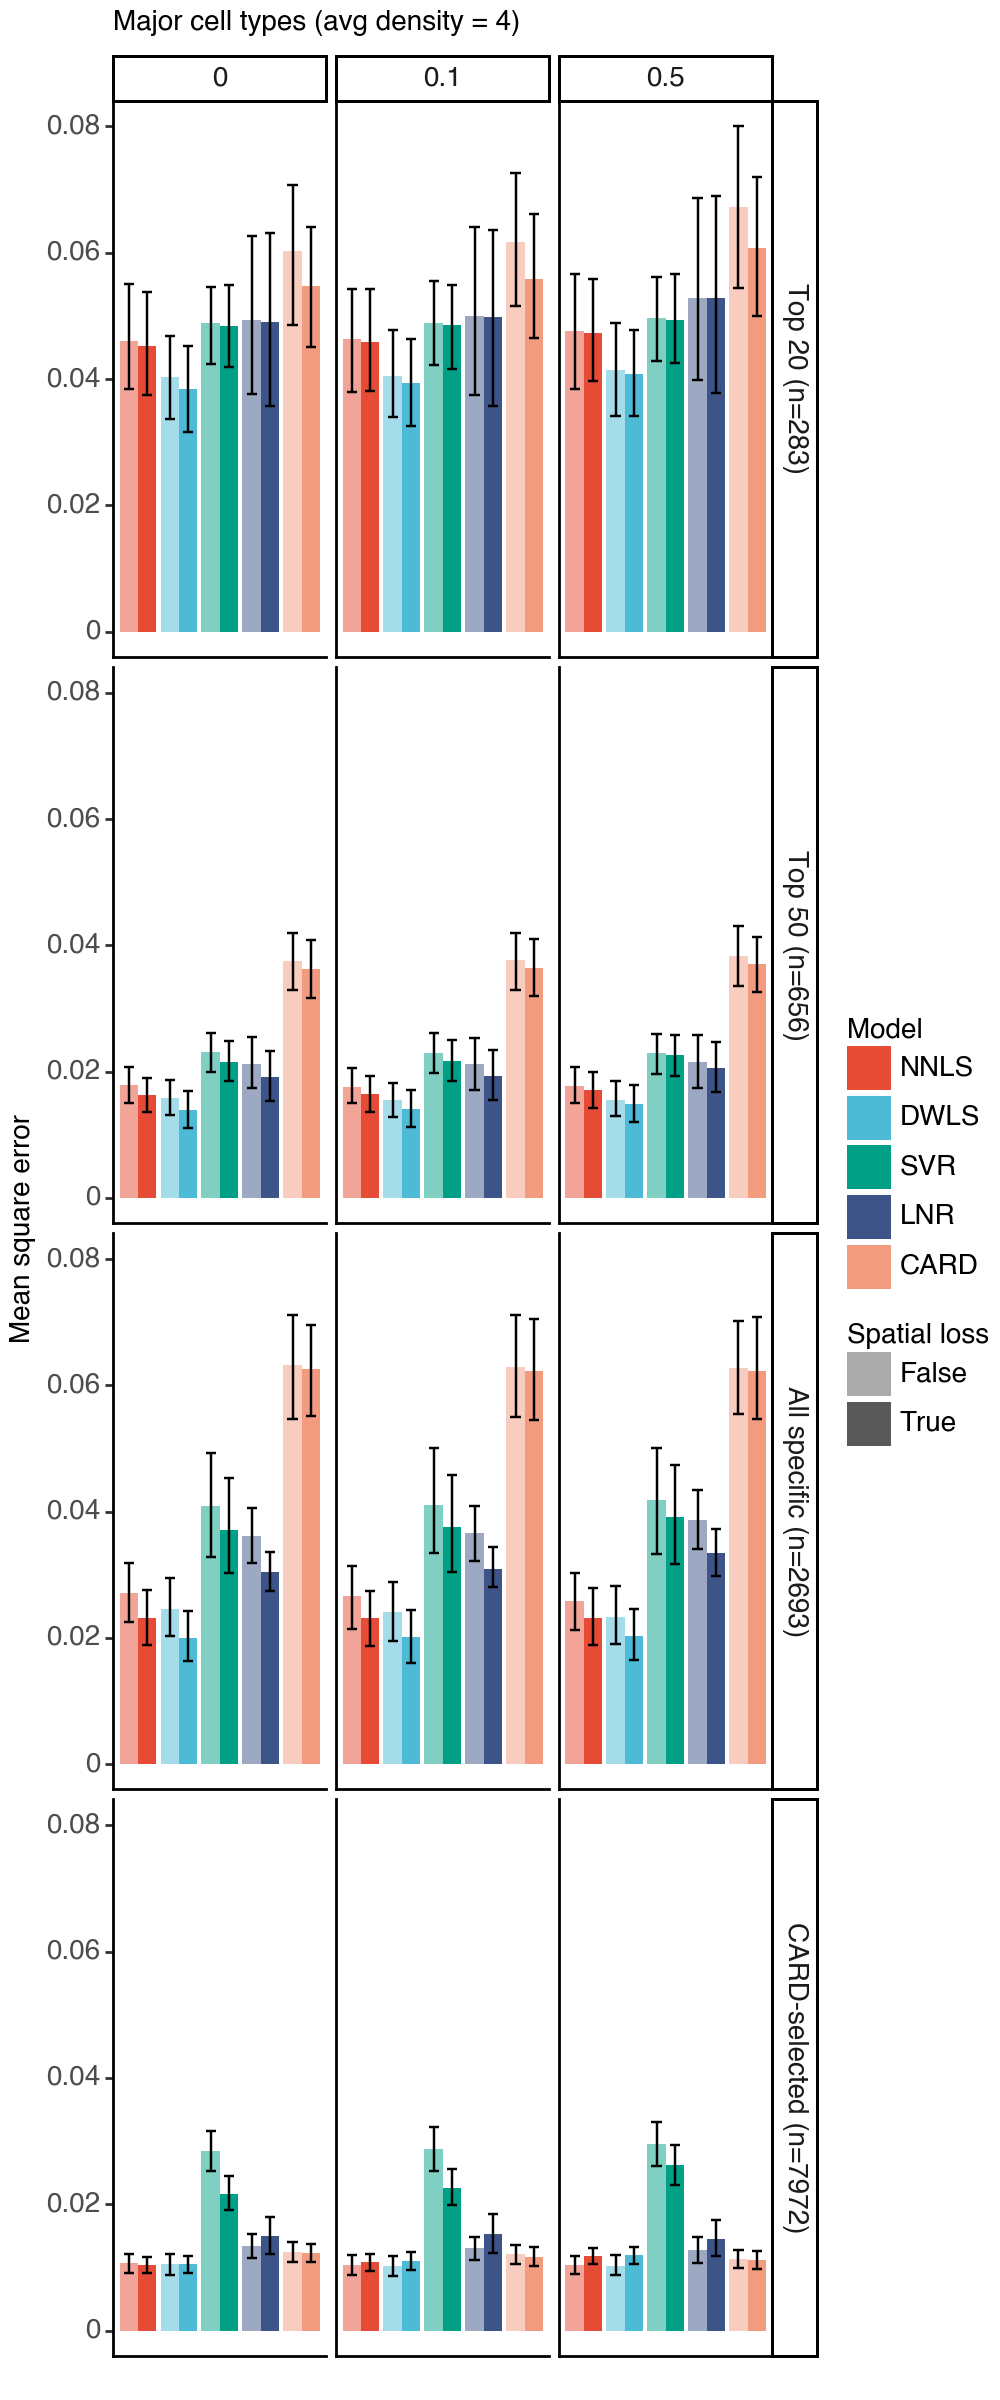

<Figure Size: (500 x 1200)>

In [5]:
(
    ggplot(err_all_df[err_all_df.is_high_density == 1], 
           aes(x='deconv_model', y = 'mse', group = 'model')) +
        facet_grid('nm ~ sm', scales = 'fixed') +
        geom_bar(aes(alpha = 'spatial_loss', fill = 'deconv_model'),
                 position = "dodge", stat = "summary",
                 fun_y = np.mean) +
        scale_fill_npg() + 
        scale_alpha_manual([0.5,1]) +
        geom_errorbar(stat = "summary", position = position_dodge(width=0.9)) +
        labs(x = '', y = 'Mean square error', title = 'Major cell types (avg density = 4)',
             fill = 'Model', alpha = 'Spatial loss') +
        theme_classic() +
        theme(figure_size = (5, 12), 
              text = element_text(size=10),
             axis_text_x=element_blank(),
             axis_ticks_major_x=element_blank())
)

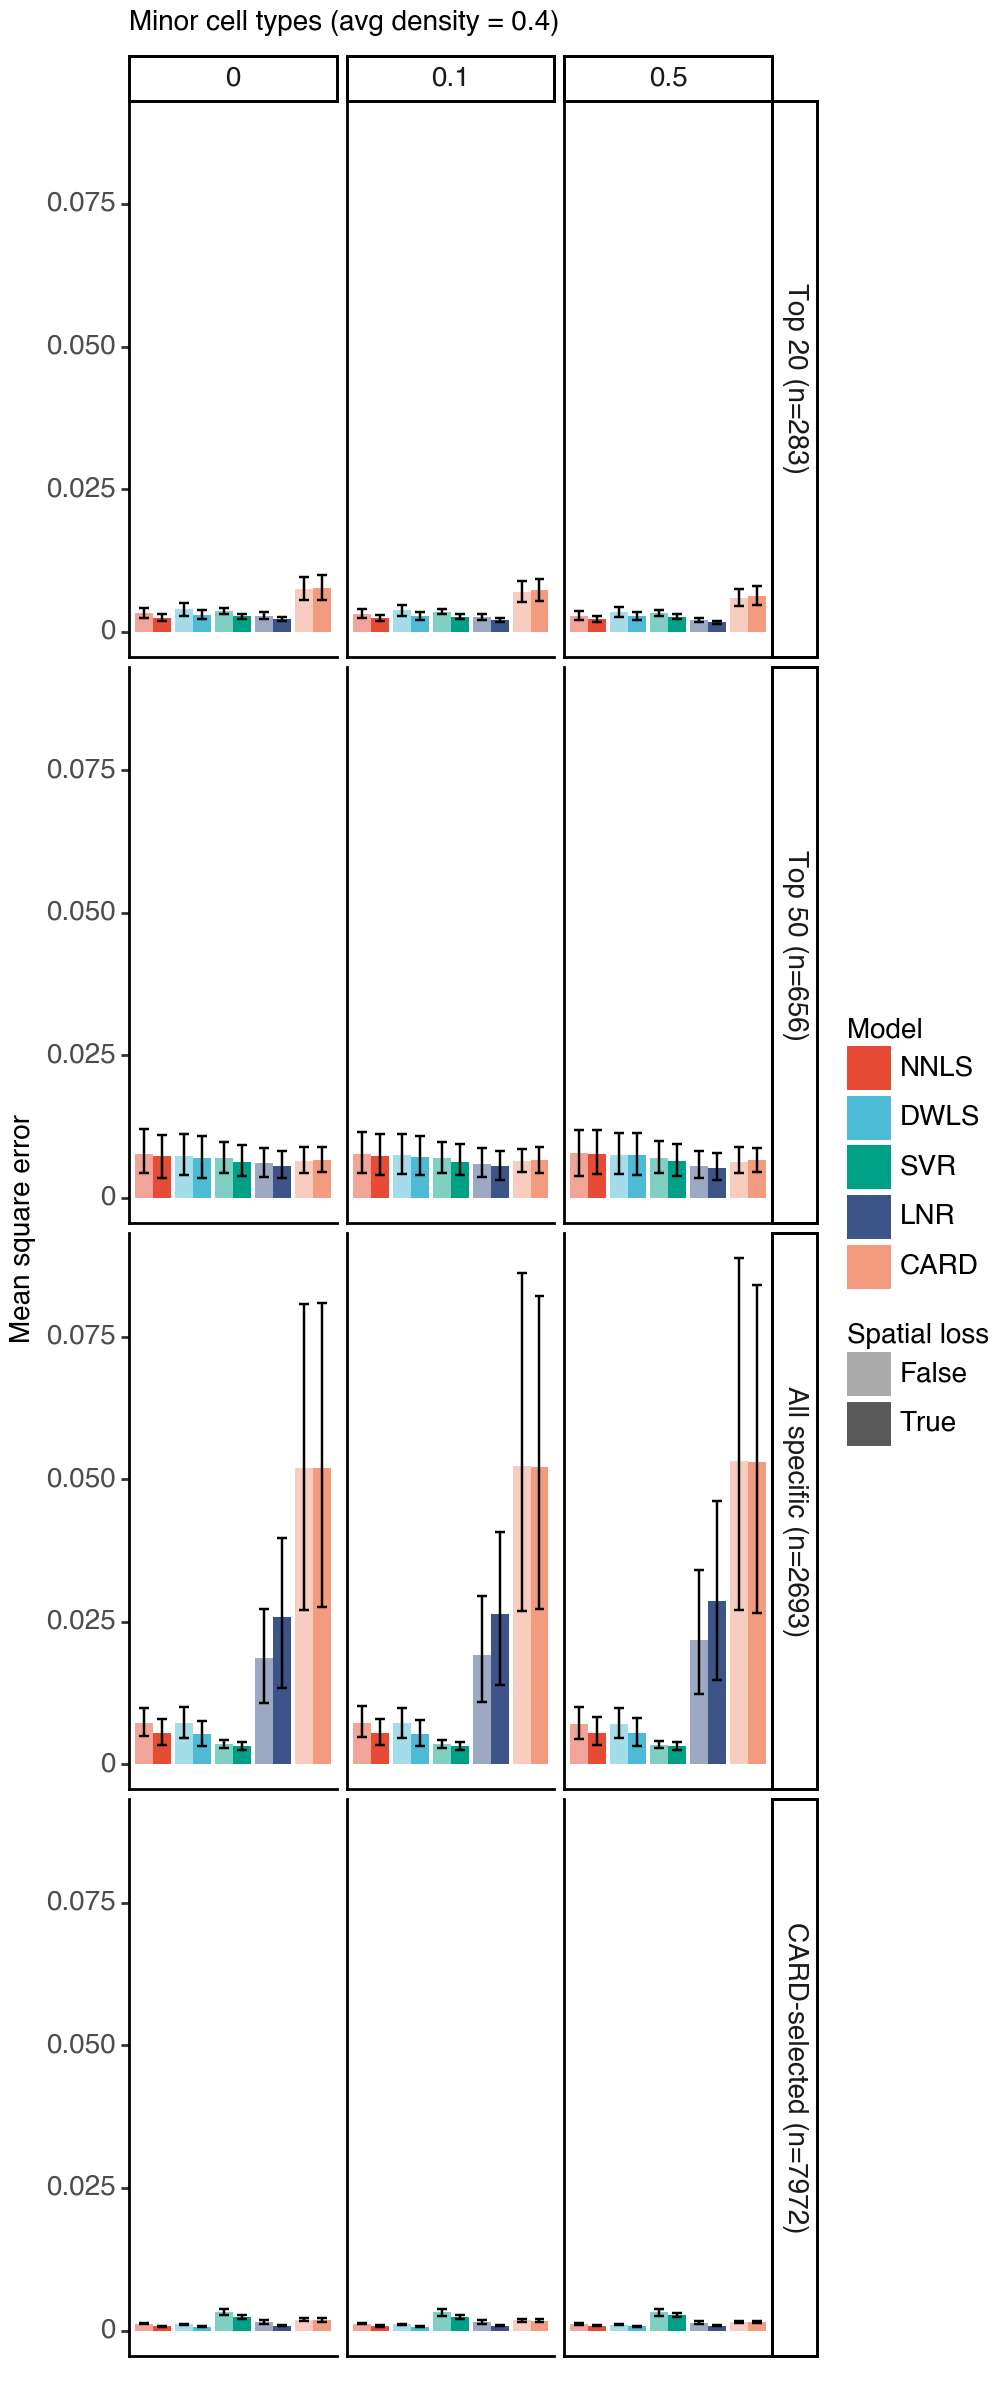

<Figure Size: (500 x 1200)>

In [6]:
(
    ggplot(err_all_df[err_all_df.is_high_density == 0], 
           aes(x='deconv_model', y = 'mse', group = 'model')) +
    facet_grid('nm ~ sm', scales = 'fixed') +
    geom_bar(aes(alpha = 'spatial_loss', fill = 'deconv_model'),
                position = "dodge", stat = "summary",
                fun_y = np.mean) +
    scale_fill_npg() + 
    scale_alpha_manual([0.5,1]) +
    geom_errorbar(stat = "summary", position = position_dodge(width=0.9)) +
    labs(x = '', y = 'Mean square error', title = 'Minor cell types (avg density = 0.4)',
            fill = 'Model', alpha = 'Spatial loss') +
    theme_classic() +
    theme(figure_size = (5, 12), 
          text = element_text(size=10),
             axis_text_x=element_blank(),
             axis_ticks_major_x=element_blank())
)

### Differences w/wo spatial loss

In [7]:
df = err_all_df.sort_values(by = ['cell_type', 'deconv_model', 
                                  'exp', 'nm', 'sm'])
df_diff_err = df[['cell_type', 'deconv_model', 'exp', 'nm', 'sm',
                  'spatial_loss', 'is_high_density']]
df_diff_err['err_diff'] = df['mse'].to_numpy() - \
    np.repeat(df[~df.spatial_loss]['mse'].to_numpy(), 2)
df_diff_err = df_diff_err[df_diff_err.spatial_loss]

/var/folders/_f/m4v2g8c54gdfks59bp2f2cm80000gn/T/ipykernel_22759/1888624735.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


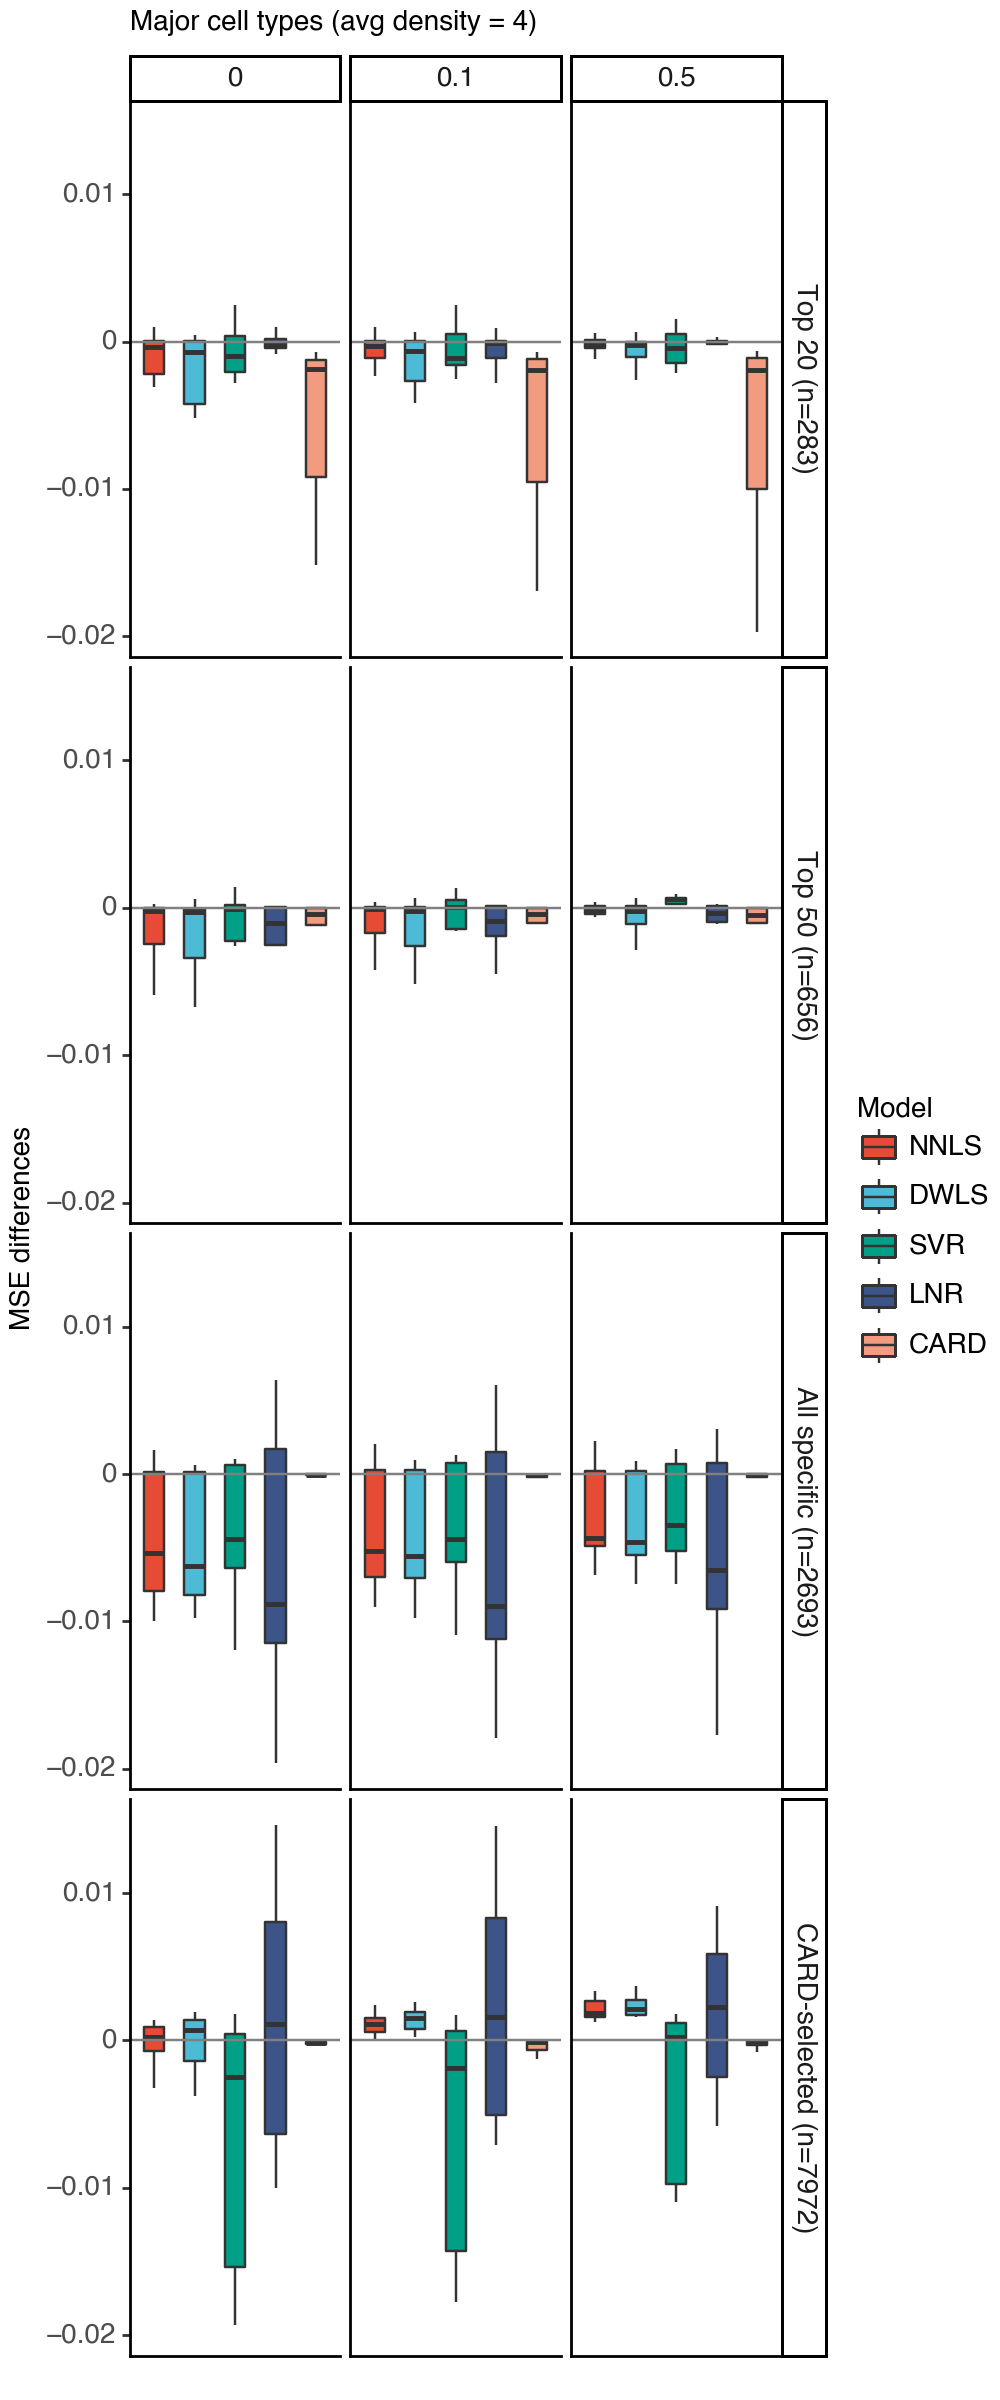

<Figure Size: (500 x 1200)>

In [8]:
(
    ggplot(df_diff_err[df_diff_err.is_high_density == 1], 
           aes(x='deconv_model', y = 'err_diff', group = 'deconv_model')) +
        facet_grid('nm ~ sm', scales = 'fixed') +
        geom_boxplot(aes(fill = 'deconv_model'), width = 0.5, outlier_shape = '') +
        geom_hline(yintercept = 0, color = 'gray') +
        scale_fill_npg() +
        labs(x = '', y = 'MSE differences', fill = 'Model',
             title = 'Major cell types (avg density = 4)') +
        theme_classic() +
        scale_y_continuous() +
        theme(figure_size = (5, 12), 
              text = element_text(size=10),
              axis_text_x=element_blank(),
              axis_ticks_major_x=element_blank())
)

/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 97 rows containing non-finite values.


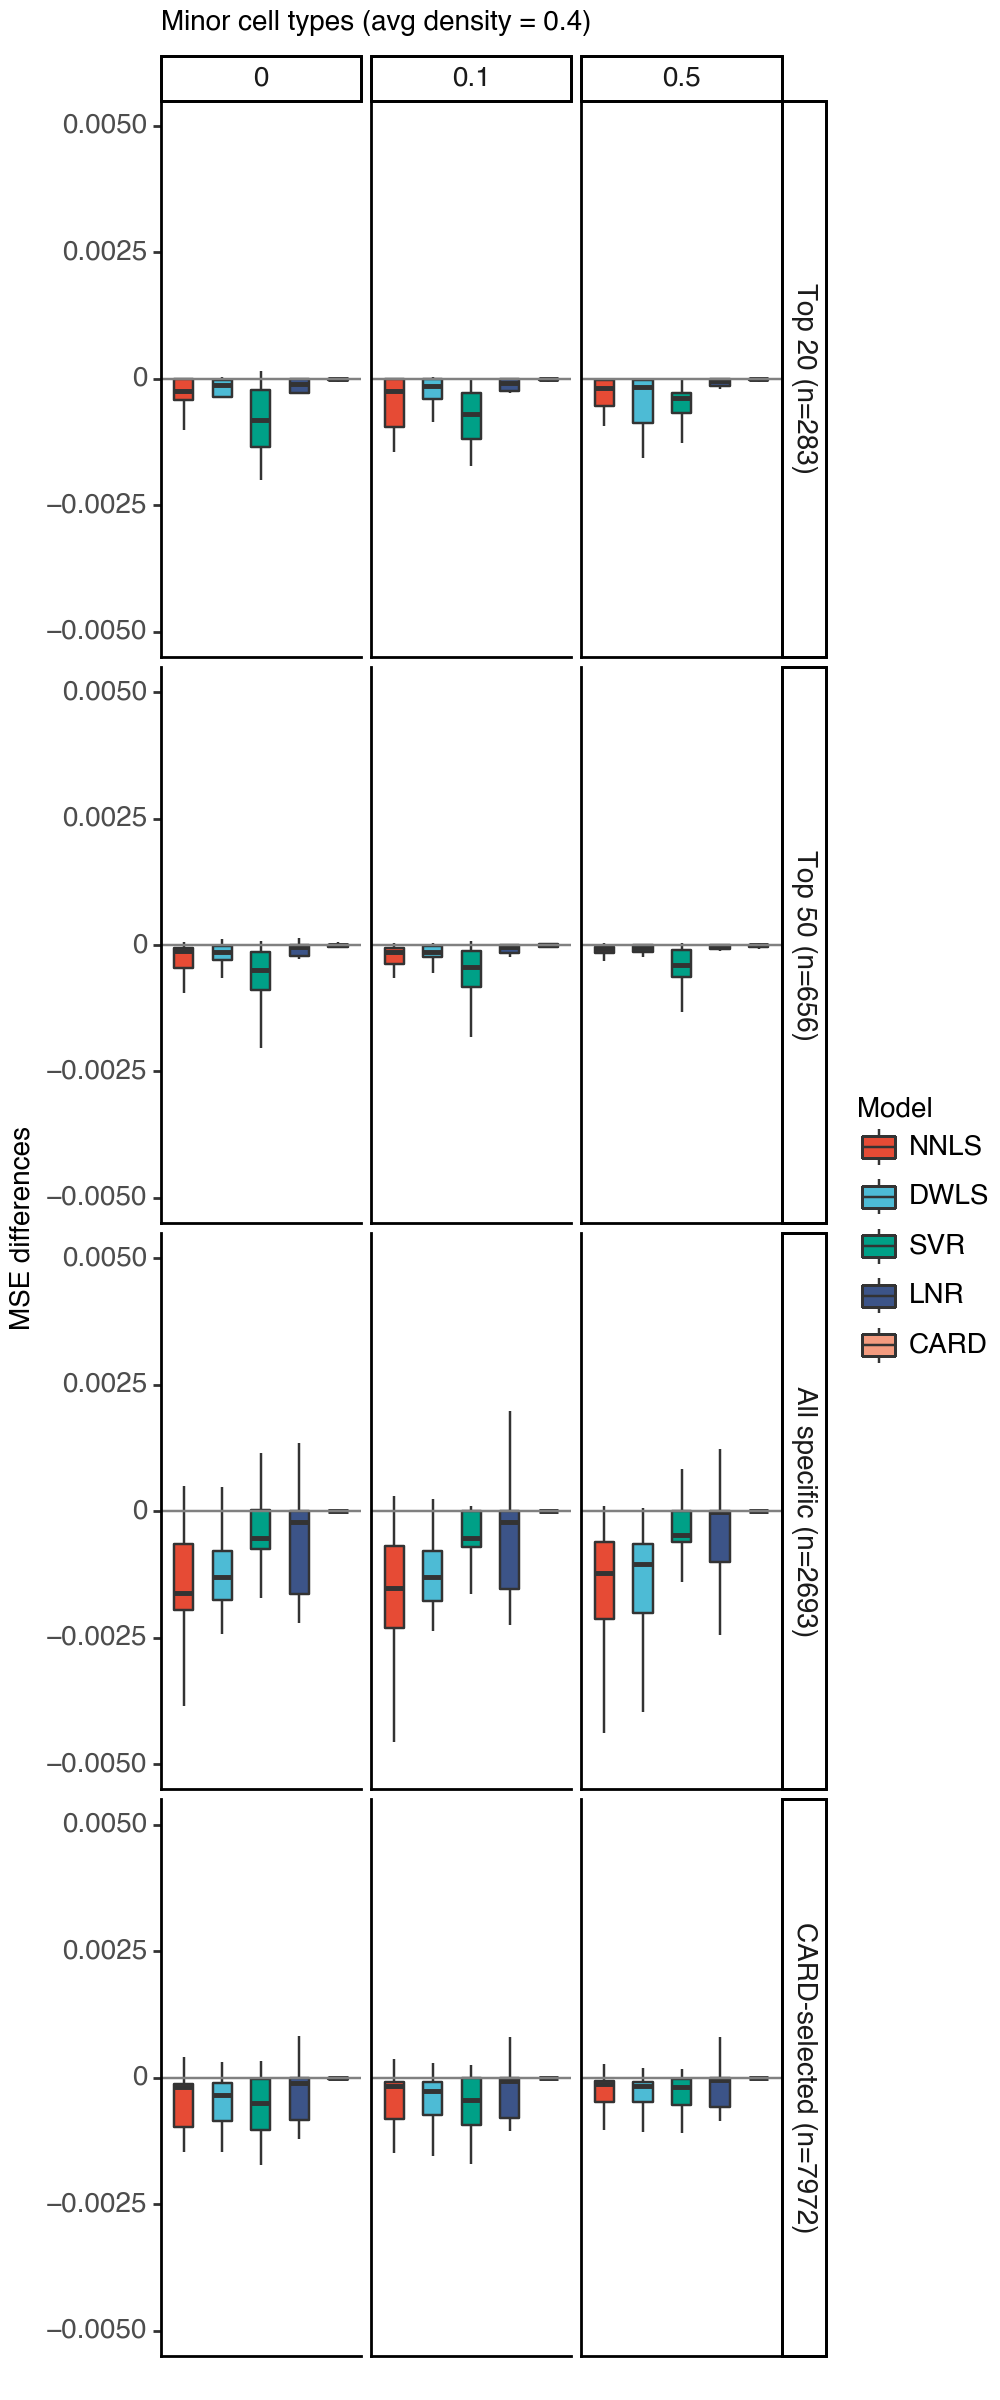

<Figure Size: (500 x 1200)>

In [9]:
(
    ggplot(df_diff_err[df_diff_err.is_high_density == 0], 
           aes(x='deconv_model', y = 'err_diff', group = 'deconv_model')) +
        facet_grid('nm ~ sm', scales = 'fixed') +
        geom_boxplot(aes(fill = 'deconv_model'), width = 0.5, outlier_shape = '') +
        geom_hline(yintercept = 0, color = 'gray') +
        scale_fill_npg() +
        labs(x = '', y = 'MSE differences', fill = 'Model',
             title = 'Minor cell types (avg density = 0.4)') +
        theme_classic() +
        scale_y_continuous(limits = [-0.005, 0.005]) +
        theme(figure_size = (5, 12), 
              text = element_text(size=10),
              axis_text_x=element_blank(),
              axis_ticks_major_x=element_blank())
)

### Pearson R

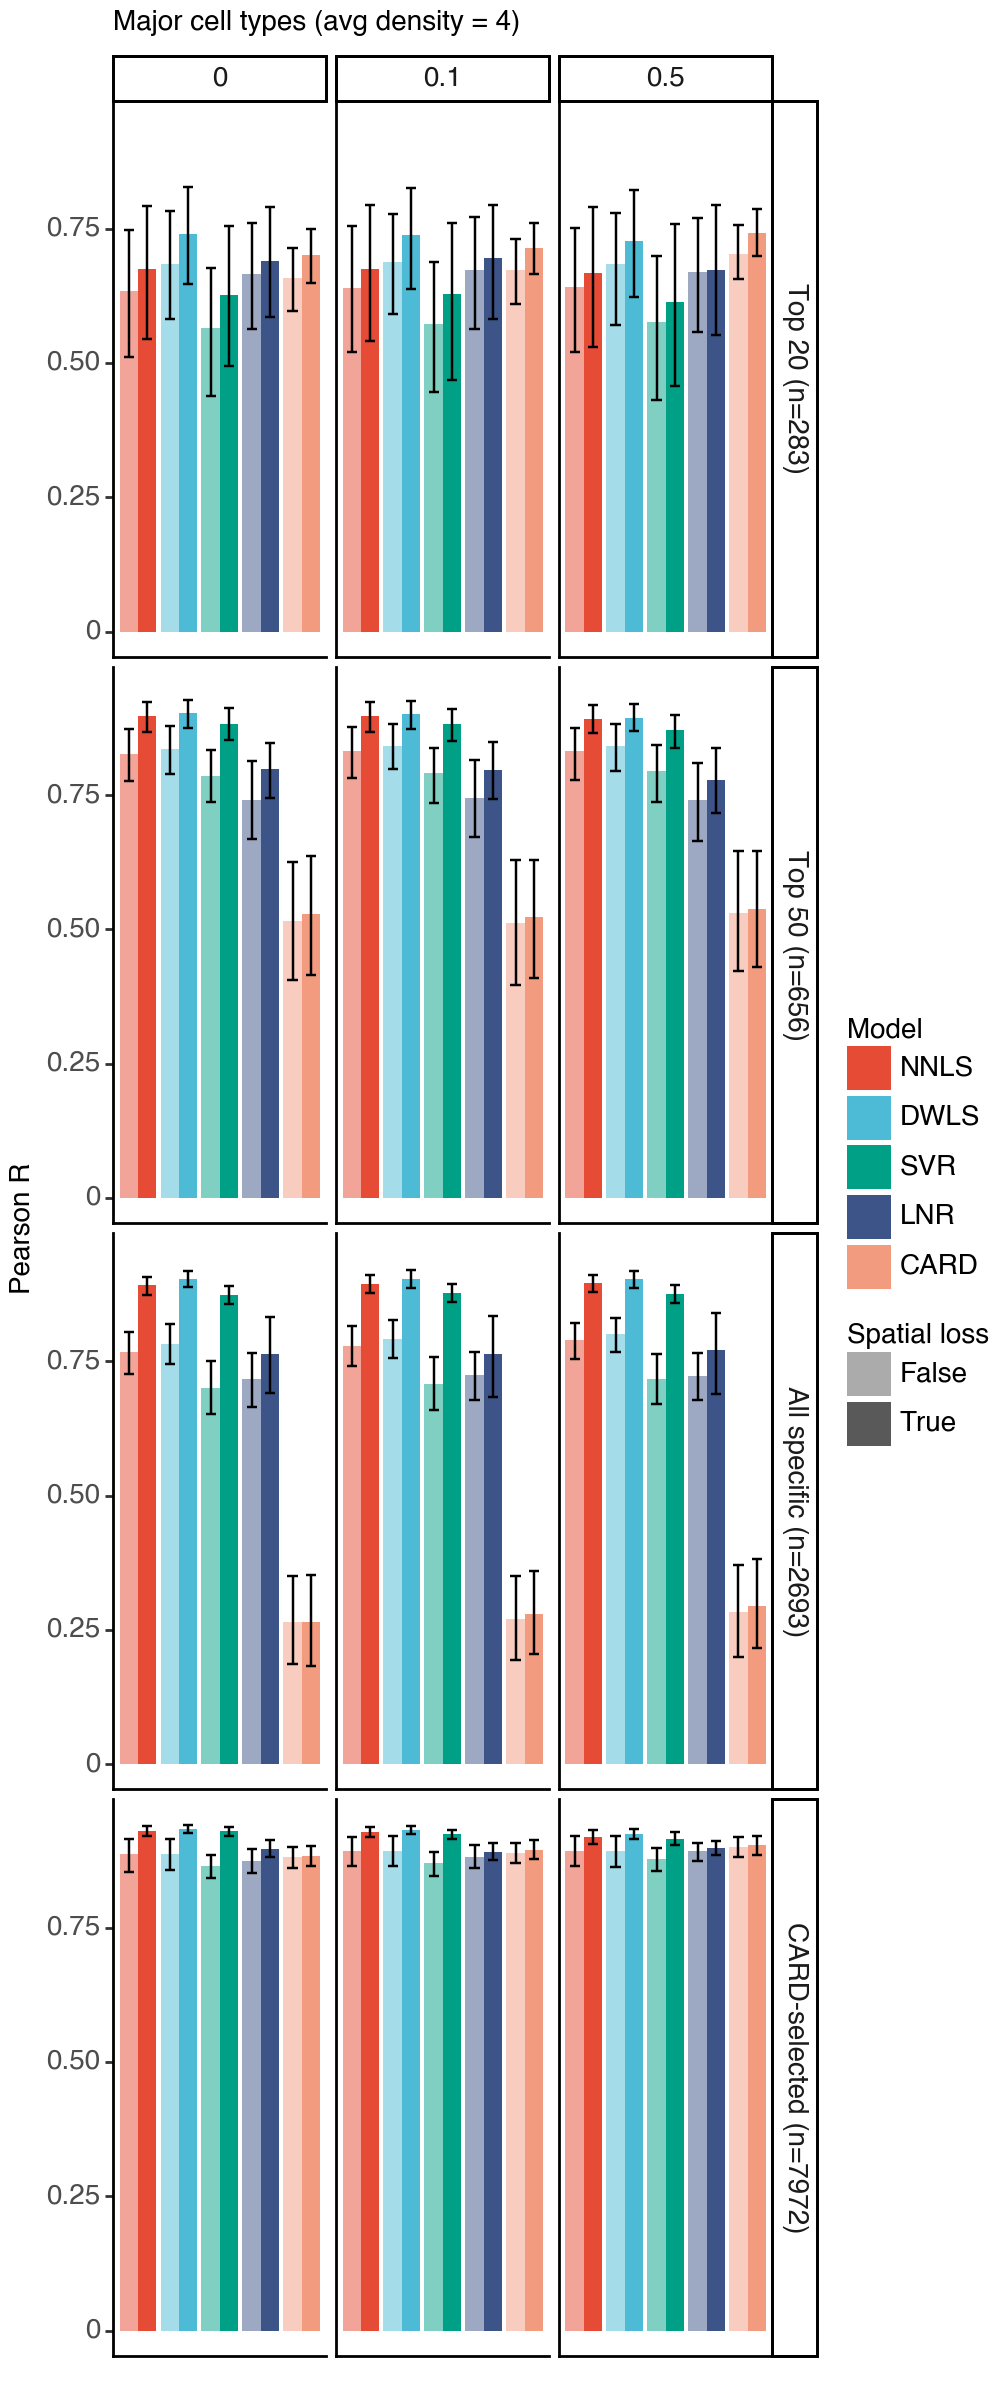

<Figure Size: (500 x 1200)>

In [10]:
(
    ggplot(corr_all_df[corr_all_df.is_high_density == 1], 
           aes(x='deconv_model', y = 'corr', group = 'model')) +
    facet_grid('nm ~ sm', scales = 'fixed') +
    geom_bar(aes(alpha = 'spatial_loss', fill = 'deconv_model'),
                position = "dodge", stat = "summary",
                fun_y = np.mean) +
    scale_fill_npg() + 
    scale_alpha_manual([0.5,1]) +
    geom_errorbar(stat = "summary", position = position_dodge(width=0.9)) +
    labs(x = '', y = 'Pearson R', title = 'Major cell types (avg density = 4)',
         fill = 'Model', alpha = 'Spatial loss') +
    theme_classic() +
    theme(figure_size = (5, 12), 
          text = element_text(size=10),
             axis_text_x = element_blank(),
             axis_ticks_major_x = element_blank())
)

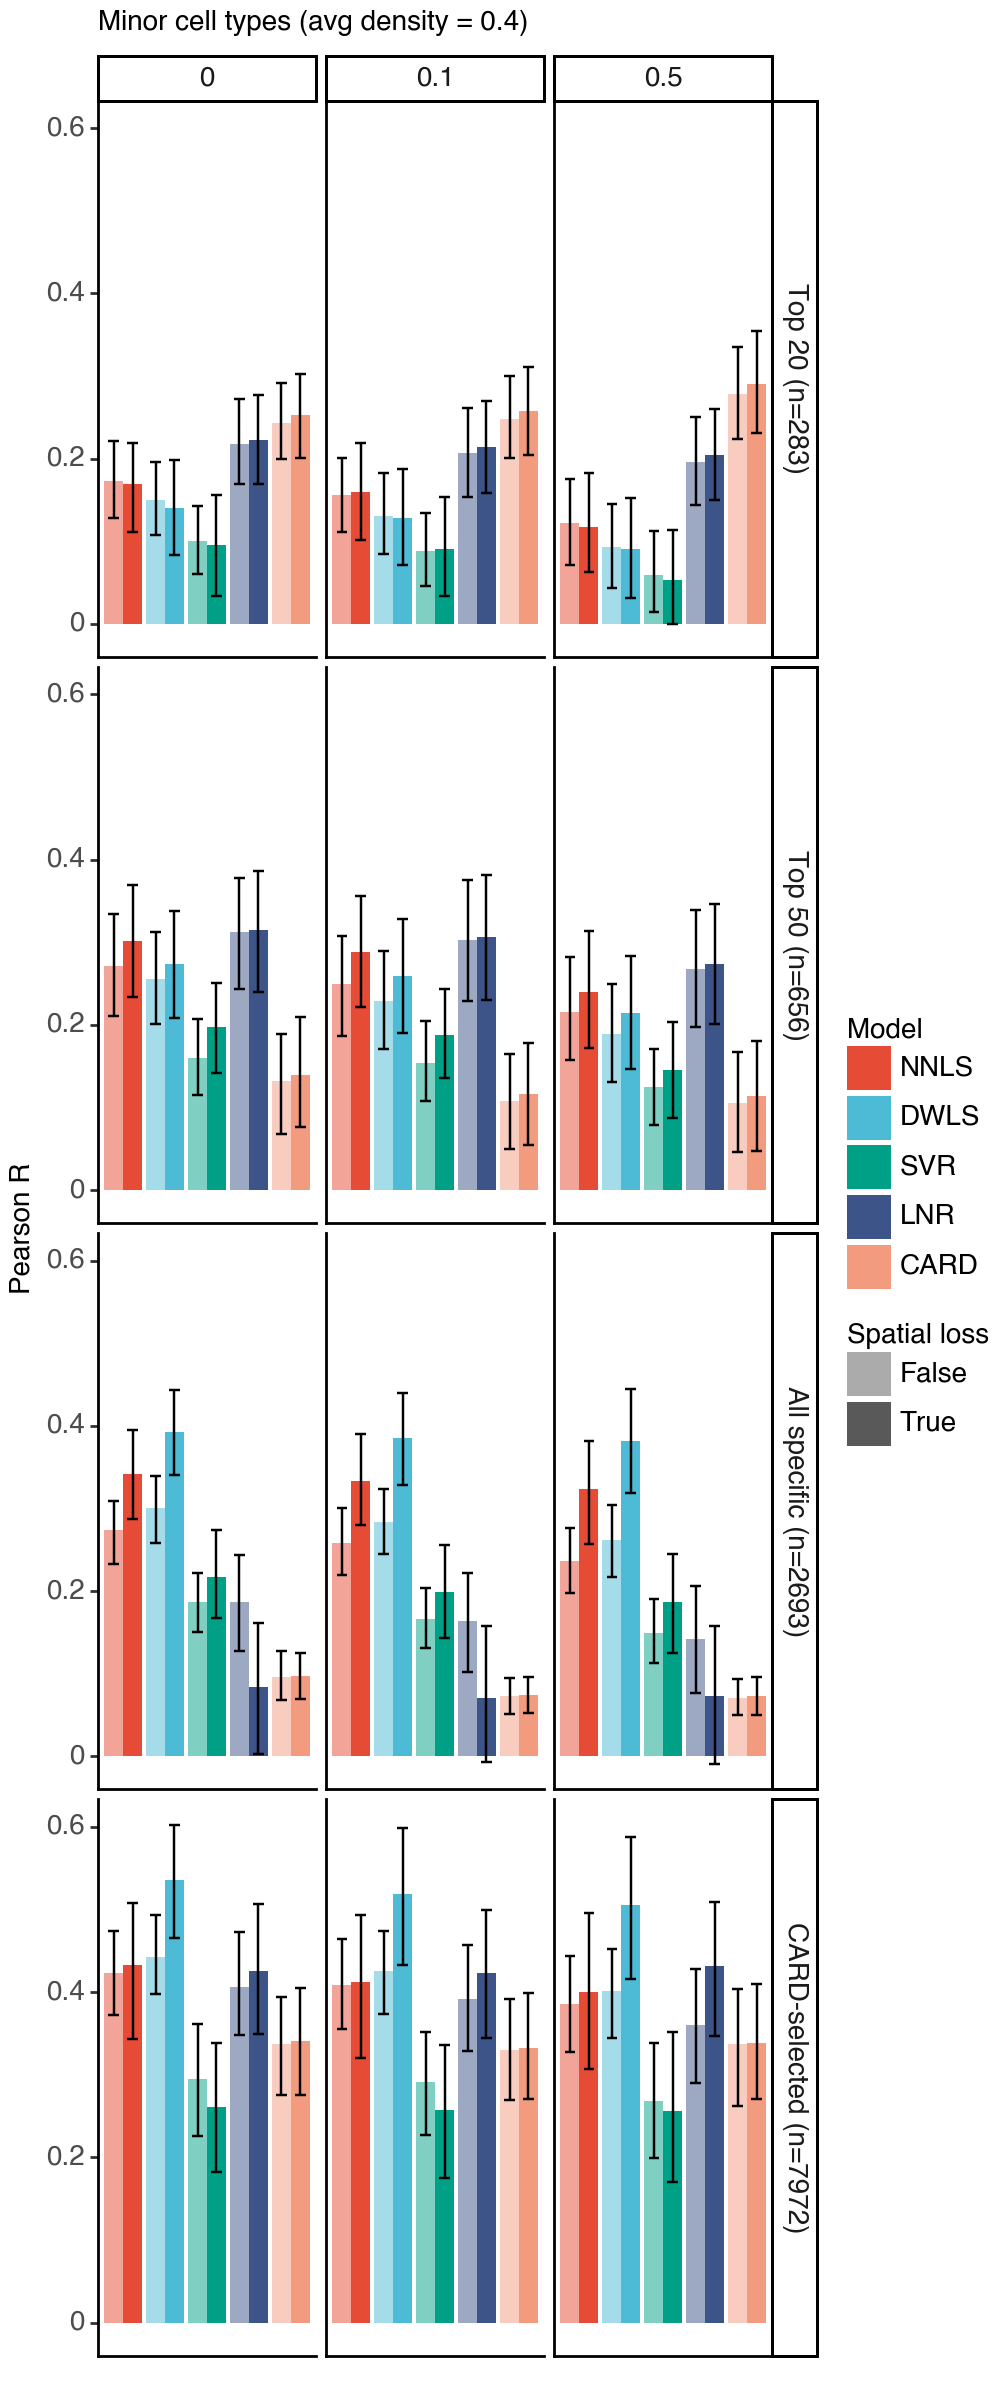

<Figure Size: (500 x 1200)>

In [11]:
(
    ggplot(corr_all_df[corr_all_df.is_high_density == 0], 
           aes(x='deconv_model', y = 'corr', group = 'model')) +
    facet_grid('nm ~ sm', scales = 'fixed') +
    geom_bar(aes(alpha = 'spatial_loss', fill = 'deconv_model'),
                position = "dodge", stat = "summary",
                fun_y = np.mean) +
    scale_fill_npg() + 
    scale_alpha_manual([0.5,1]) +
    geom_errorbar(stat = "summary", position = position_dodge(width=0.9)) +
    labs(x = '', y = 'Pearson R', title = 'Minor cell types (avg density = 0.4)',
         fill = 'Model', alpha = 'Spatial loss') +
    theme_classic() +
    theme(figure_size = (5, 12), 
          text = element_text(size=10),
             axis_text_x = element_blank(),
             axis_ticks_major_x = element_blank())
)

### Differences w/wo spatial loss

In [12]:
df = corr_all_df.sort_values(by = ['cell_type', 'deconv_model', 
                                   'exp', 'nm', 'sm'])
df_diff_corr = df[['cell_type', 'deconv_model', 'exp', 'nm', 'sm',
                   'spatial_loss', 'is_high_density']]
df_diff_corr['corr_diff'] = df['corr'].to_numpy() - \
    np.repeat(df[~df.spatial_loss]['corr'].to_numpy(), 2)
df_diff_corr = df_diff_corr[df_diff_corr.spatial_loss]

/var/folders/_f/m4v2g8c54gdfks59bp2f2cm80000gn/T/ipykernel_22759/809051672.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


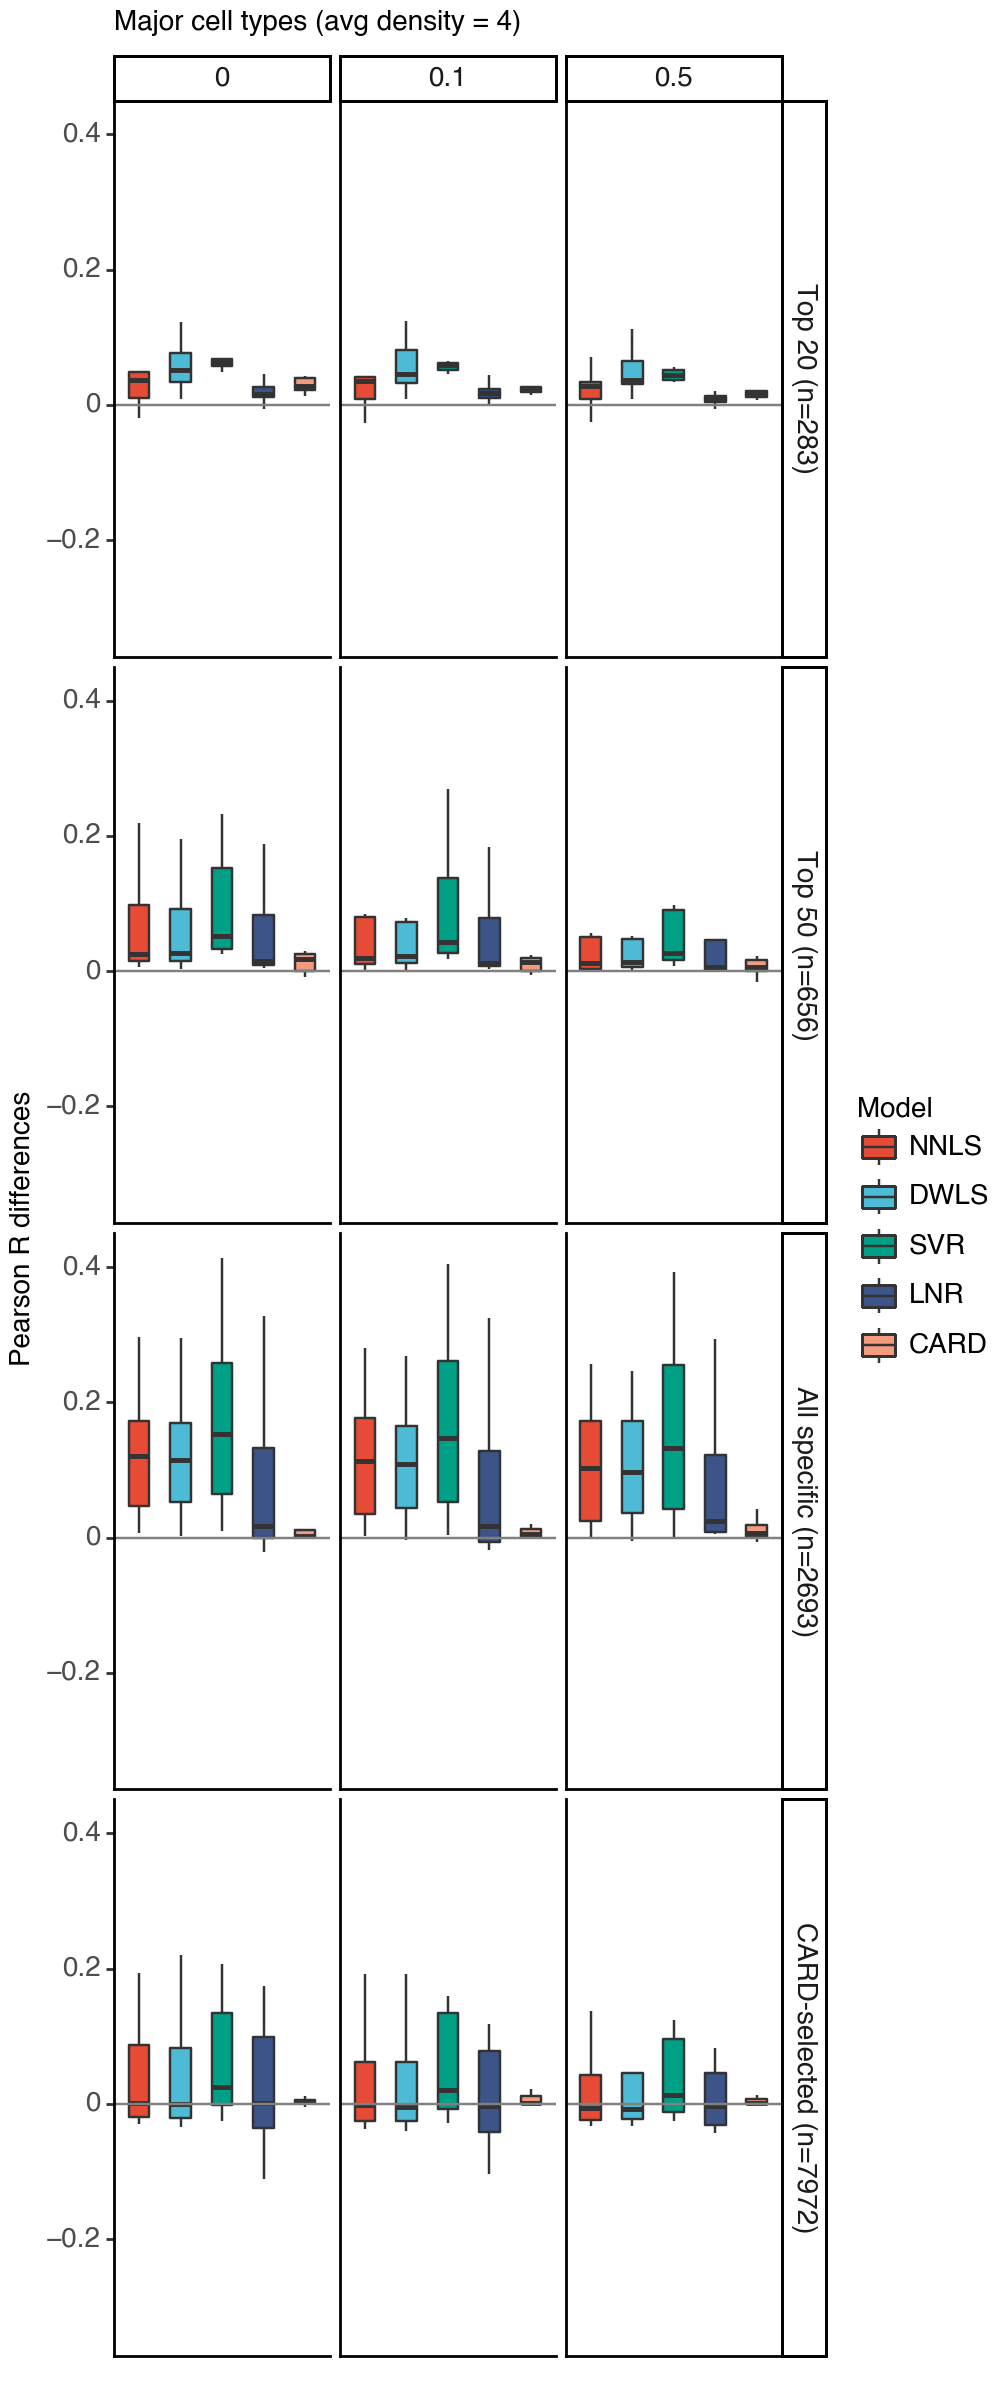

<Figure Size: (500 x 1200)>

In [13]:
(
    ggplot(df_diff_corr[df_diff_corr.is_high_density == 1], 
           aes(x='deconv_model', y = 'corr_diff', group = 'deconv_model')) +
    facet_grid('nm ~ sm', scales = 'fixed') +
    geom_boxplot(aes(fill = 'deconv_model'), width = 0.5, outlier_shape = '') +
    geom_hline(yintercept = 0, color = 'gray') +
    labs(x = '', y = 'Pearson R differences', fill = 'Model',
         title = 'Major cell types (avg density = 4)') +
    scale_fill_npg() + 
    theme_classic() +
    scale_y_continuous() +
    theme(figure_size = (5, 12), 
          text = element_text(size=10),
             axis_text_x=element_blank(),
             axis_ticks_major_x=element_blank())
)


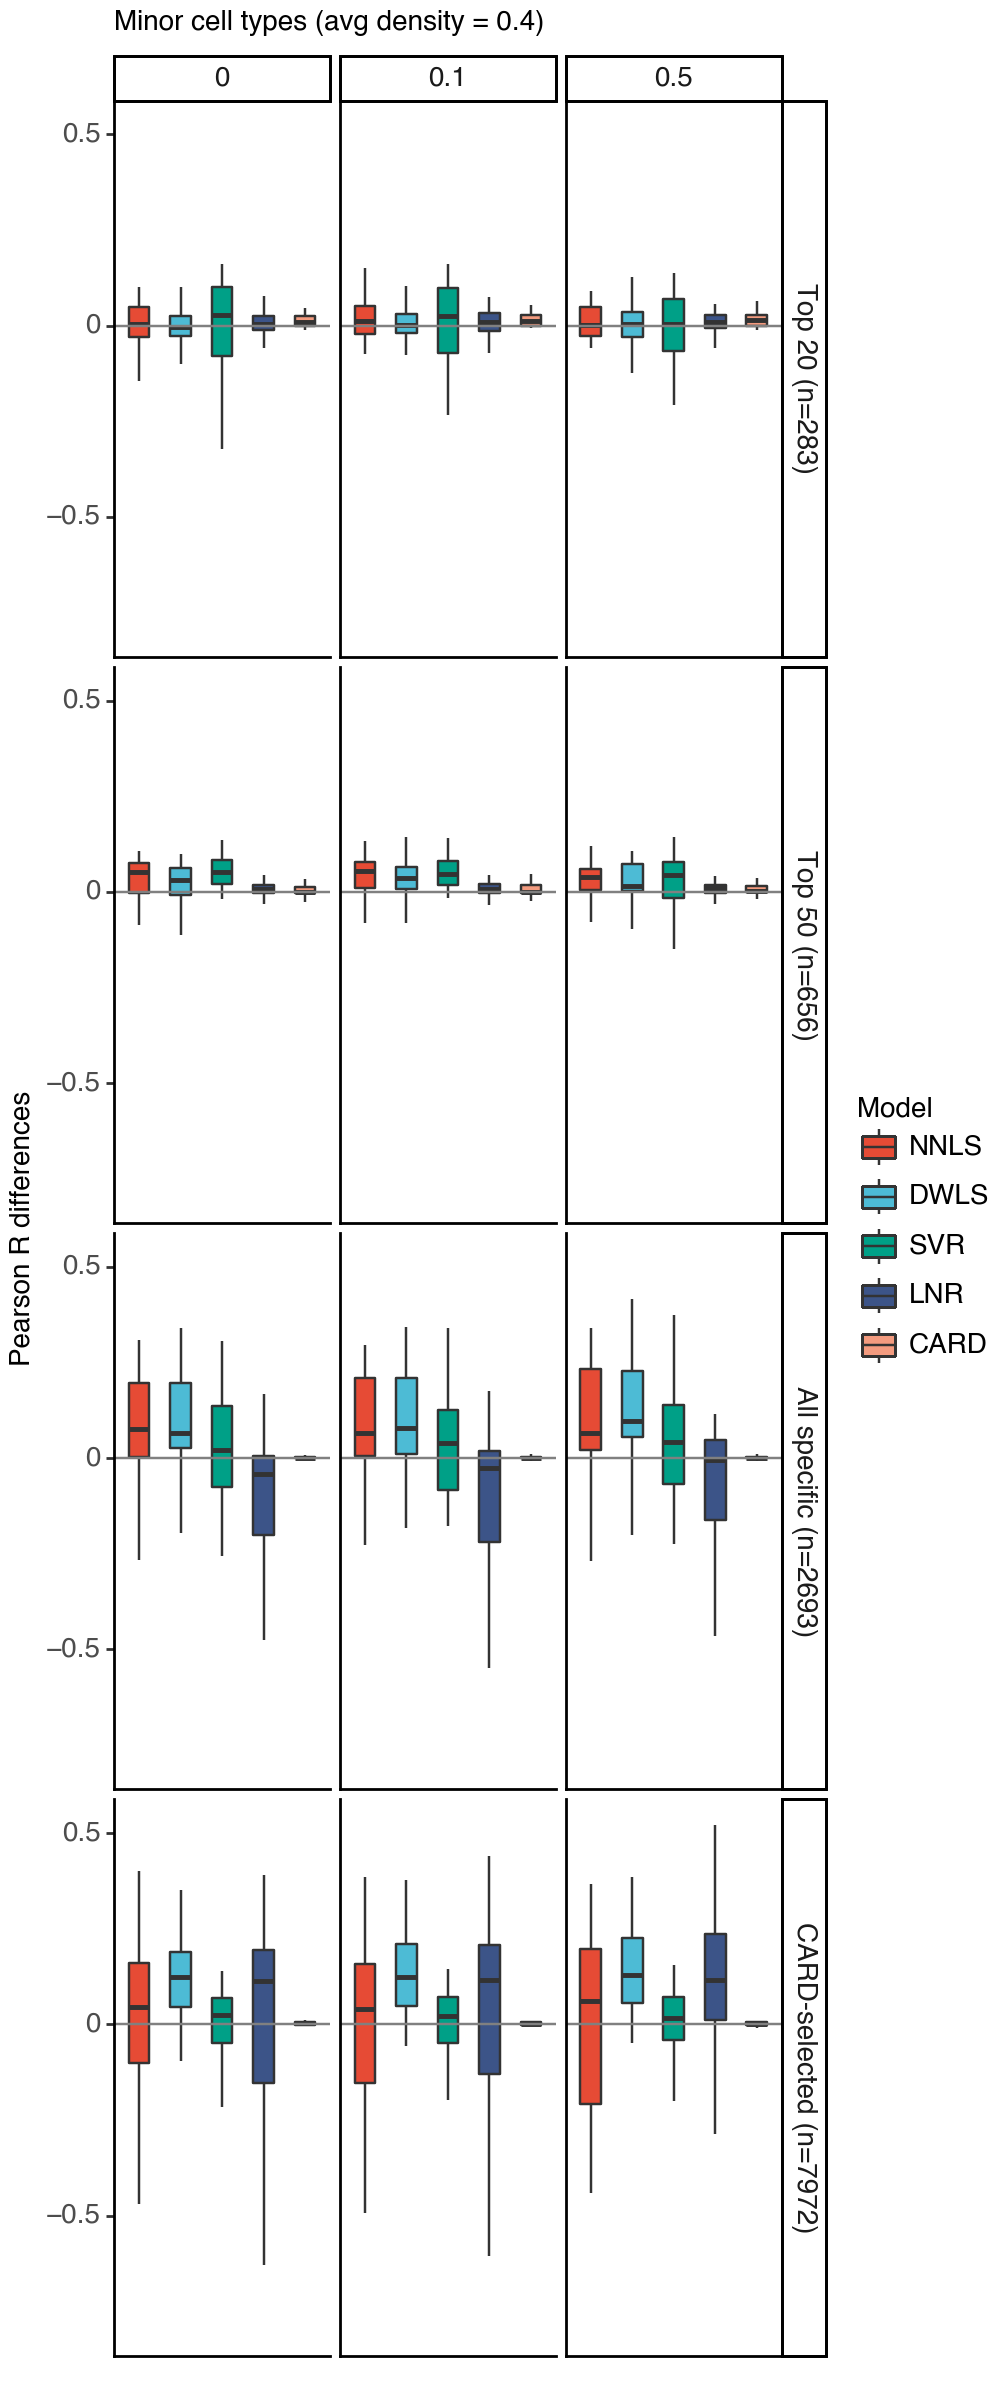

<Figure Size: (500 x 1200)>

In [14]:
(
    ggplot(df_diff_corr[df_diff_corr.is_high_density == 0], 
                aes(x='deconv_model', y = 'corr_diff', group = 'deconv_model')) +
    facet_grid('nm ~ sm', scales = 'fixed') +
    geom_boxplot(aes(fill = 'deconv_model'), width = 0.5, outlier_shape = '') +
    geom_hline(yintercept = 0, color = 'gray') +
    labs(x = '', y = 'Pearson R differences', fill = 'Model',
         title = 'Minor cell types (avg density = 0.4)') +
    scale_fill_npg() +
    theme_classic() +
    scale_y_continuous() +
    theme(figure_size = (5, 12), 
          text = element_text(size=10),
             axis_text_x=element_blank(),
             axis_ticks_major_x=element_blank())
)

## Binary accuracy

### Average precision scores

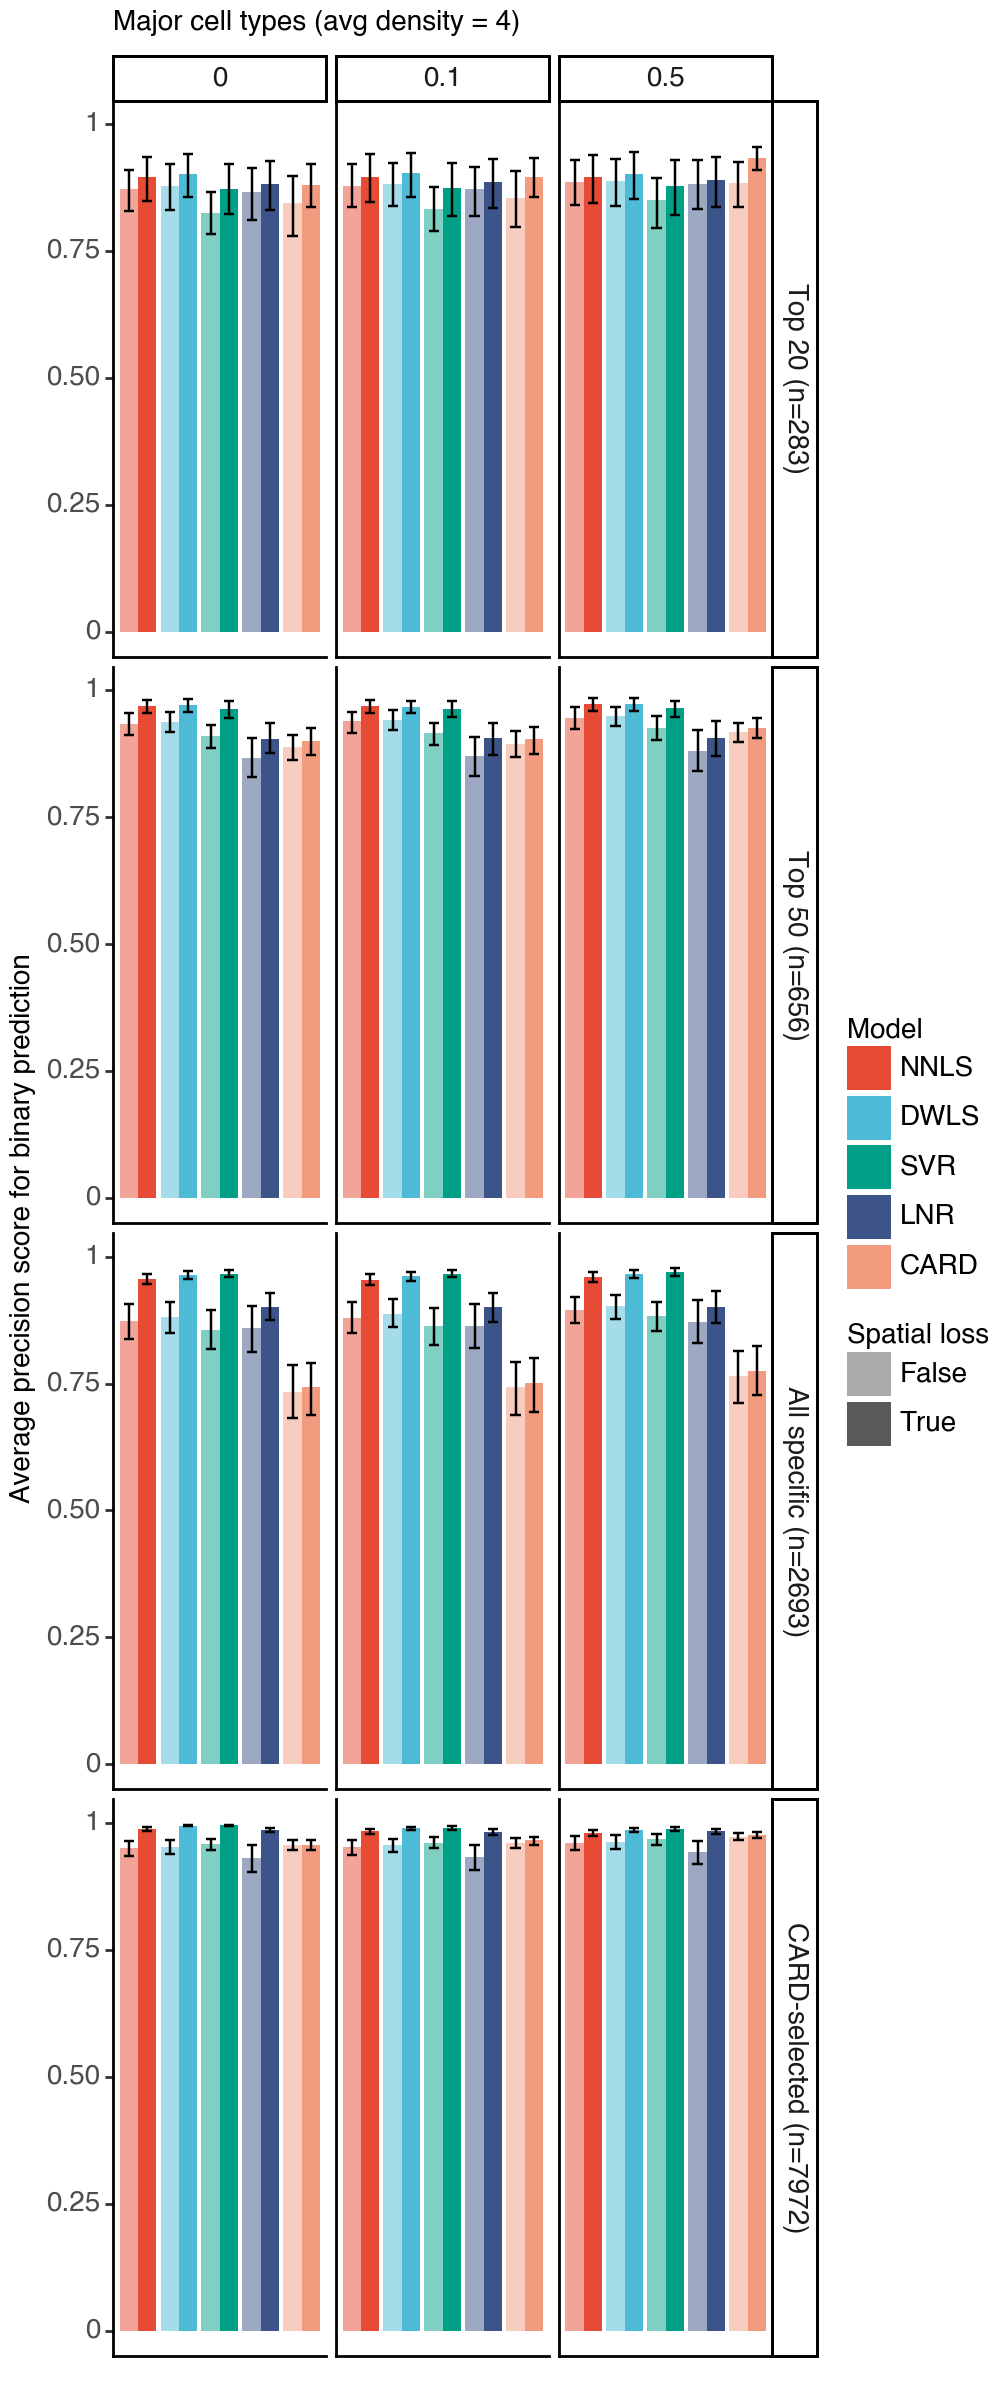

<Figure Size: (500 x 1200)>

In [15]:
(
    ggplot(accu_all_df[accu_all_df.is_high_density == 1], 
          aes(x='deconv_model', y = 'accu', group = 'model')) +
    facet_grid('nm ~ sm', scales = 'fixed') +
    geom_bar(aes(alpha = 'spatial_loss', fill = 'deconv_model'),
                position = "dodge", stat = "summary",
                fun_y = np.mean) +
    scale_fill_npg() +
    scale_alpha_manual([0.5,1]) +
    geom_errorbar(stat = "summary", position = position_dodge(width=0.9)) +
    labs(x = '', y = 'Average precision score for binary prediction',
         title = 'Major cell types (avg density = 4)',
         fill = 'Model', alpha = 'Spatial loss') +
    theme_classic() +
    theme(figure_size = (5, 12), 
          text = element_text(size=10),
             axis_text_x=element_blank(),
             axis_ticks_major_x=element_blank())
)

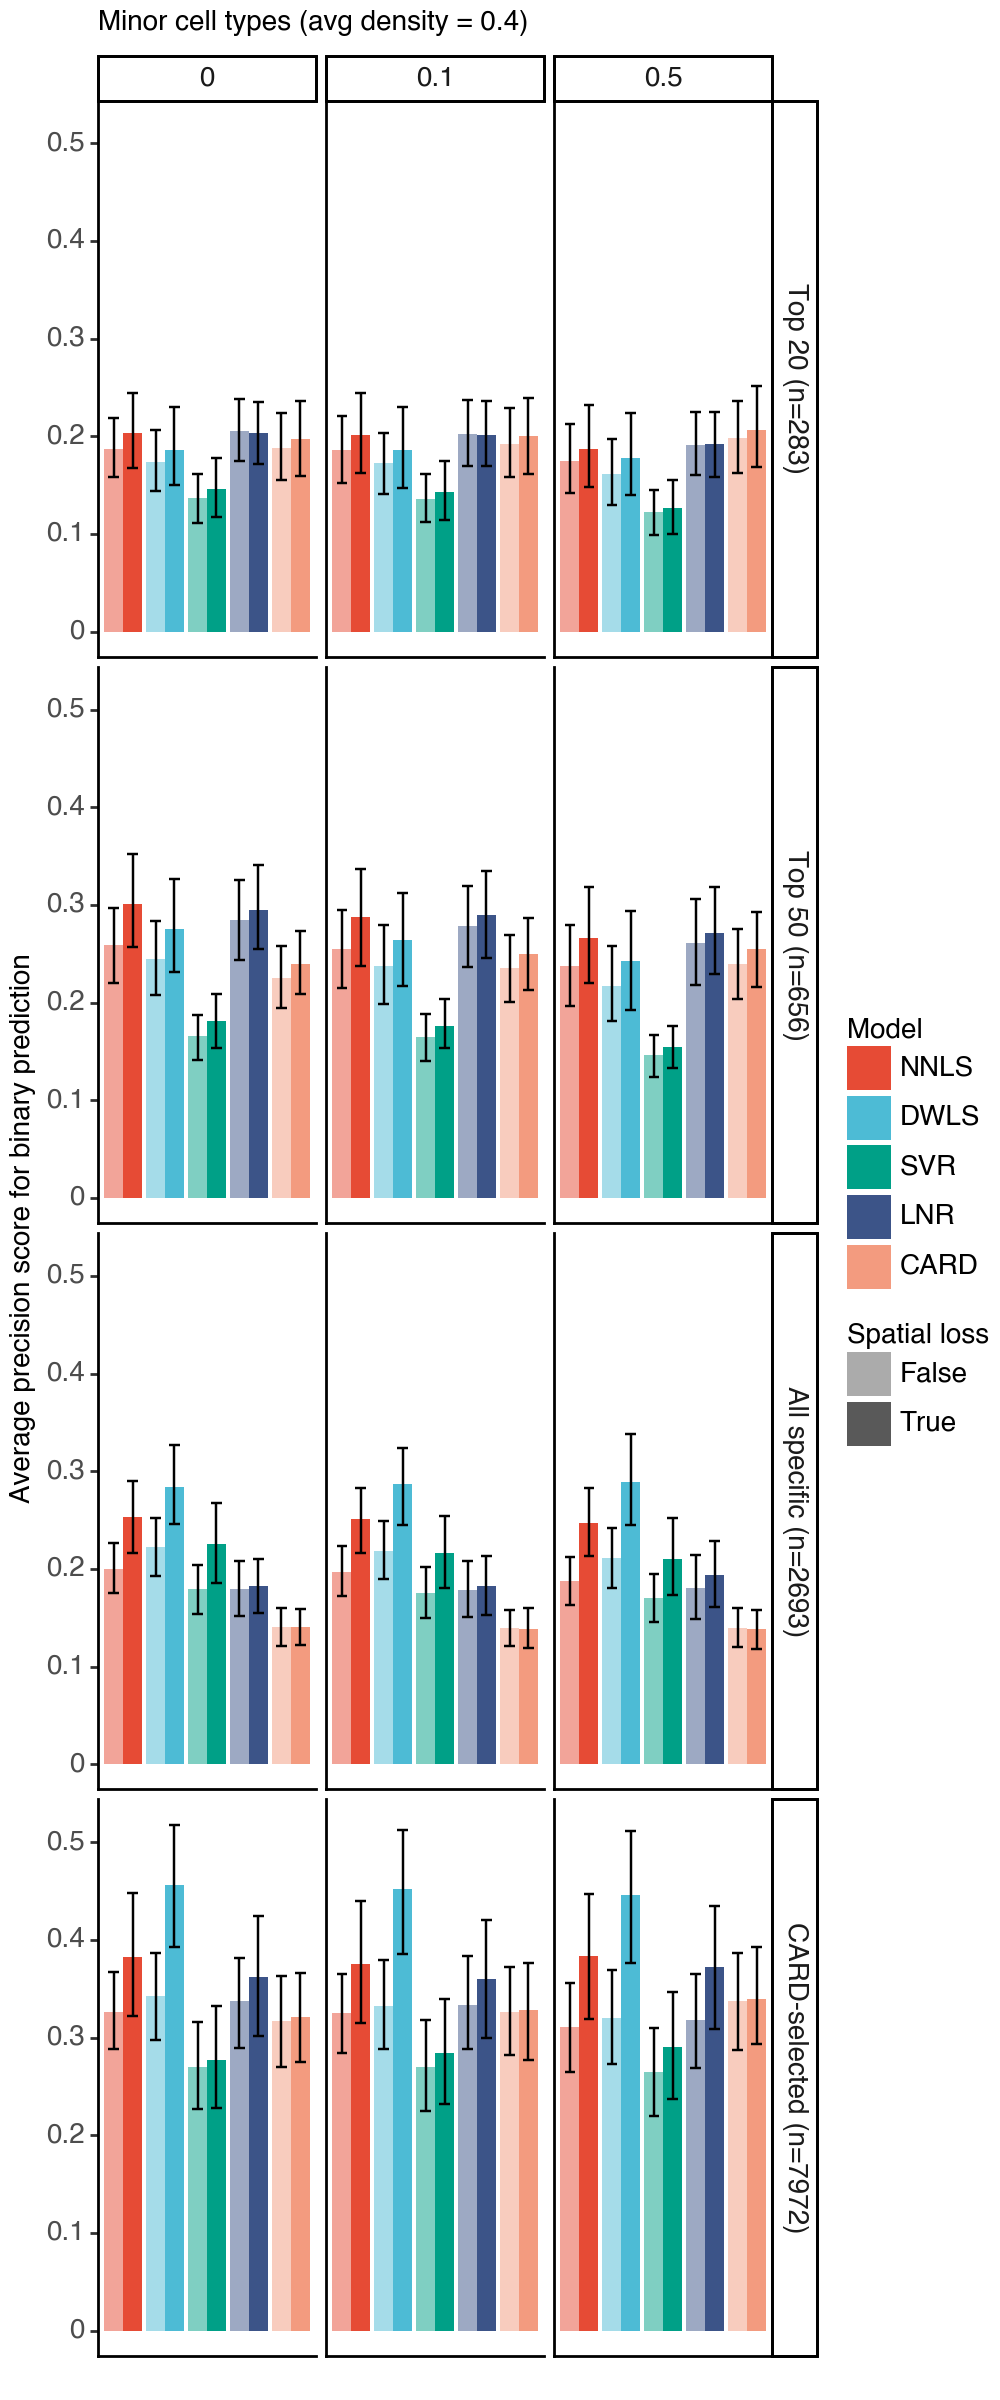

<Figure Size: (500 x 1200)>

In [16]:
(
    ggplot(accu_all_df[accu_all_df.is_high_density == 0], 
          aes(x='deconv_model', y = 'accu', group = 'model')) +
    facet_grid('nm ~ sm', scales = 'fixed') +
    geom_bar(aes(alpha = 'spatial_loss', fill = 'deconv_model'),
                position = "dodge", stat = "summary",
                fun_y = np.mean) +
    scale_fill_npg() +
    scale_alpha_manual([0.5,1]) +
    geom_errorbar(stat = "summary", position = position_dodge(width=0.9)) +
    labs(x = '', y = 'Average precision score for binary prediction',
         title = 'Minor cell types (avg density = 0.4)',
         fill = 'Model', alpha = 'Spatial loss') +
    theme_classic() +
    theme(figure_size = (5, 12), 
          text = element_text(size=10),
             axis_text_x=element_blank(),
             axis_ticks_major_x=element_blank())
)

### Differences w/wo spatial loss

In [17]:
df = accu_all_df.sort_values(by = ['cell_type', 'deconv_model', 
                                   'exp', 'nm', 'sm'])
df_diff_accu = df[['cell_type', 'deconv_model', 'exp', 'nm', 'sm',
                   'spatial_loss', 'is_high_density']]
df_diff_accu['accu_diff'] = df['accu'].to_numpy() - \
    np.repeat(df[~df.spatial_loss]['accu'].to_numpy(), 2)
df_diff_accu = df_diff_accu[df_diff_accu.spatial_loss]

/var/folders/_f/m4v2g8c54gdfks59bp2f2cm80000gn/T/ipykernel_22759/3392483780.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


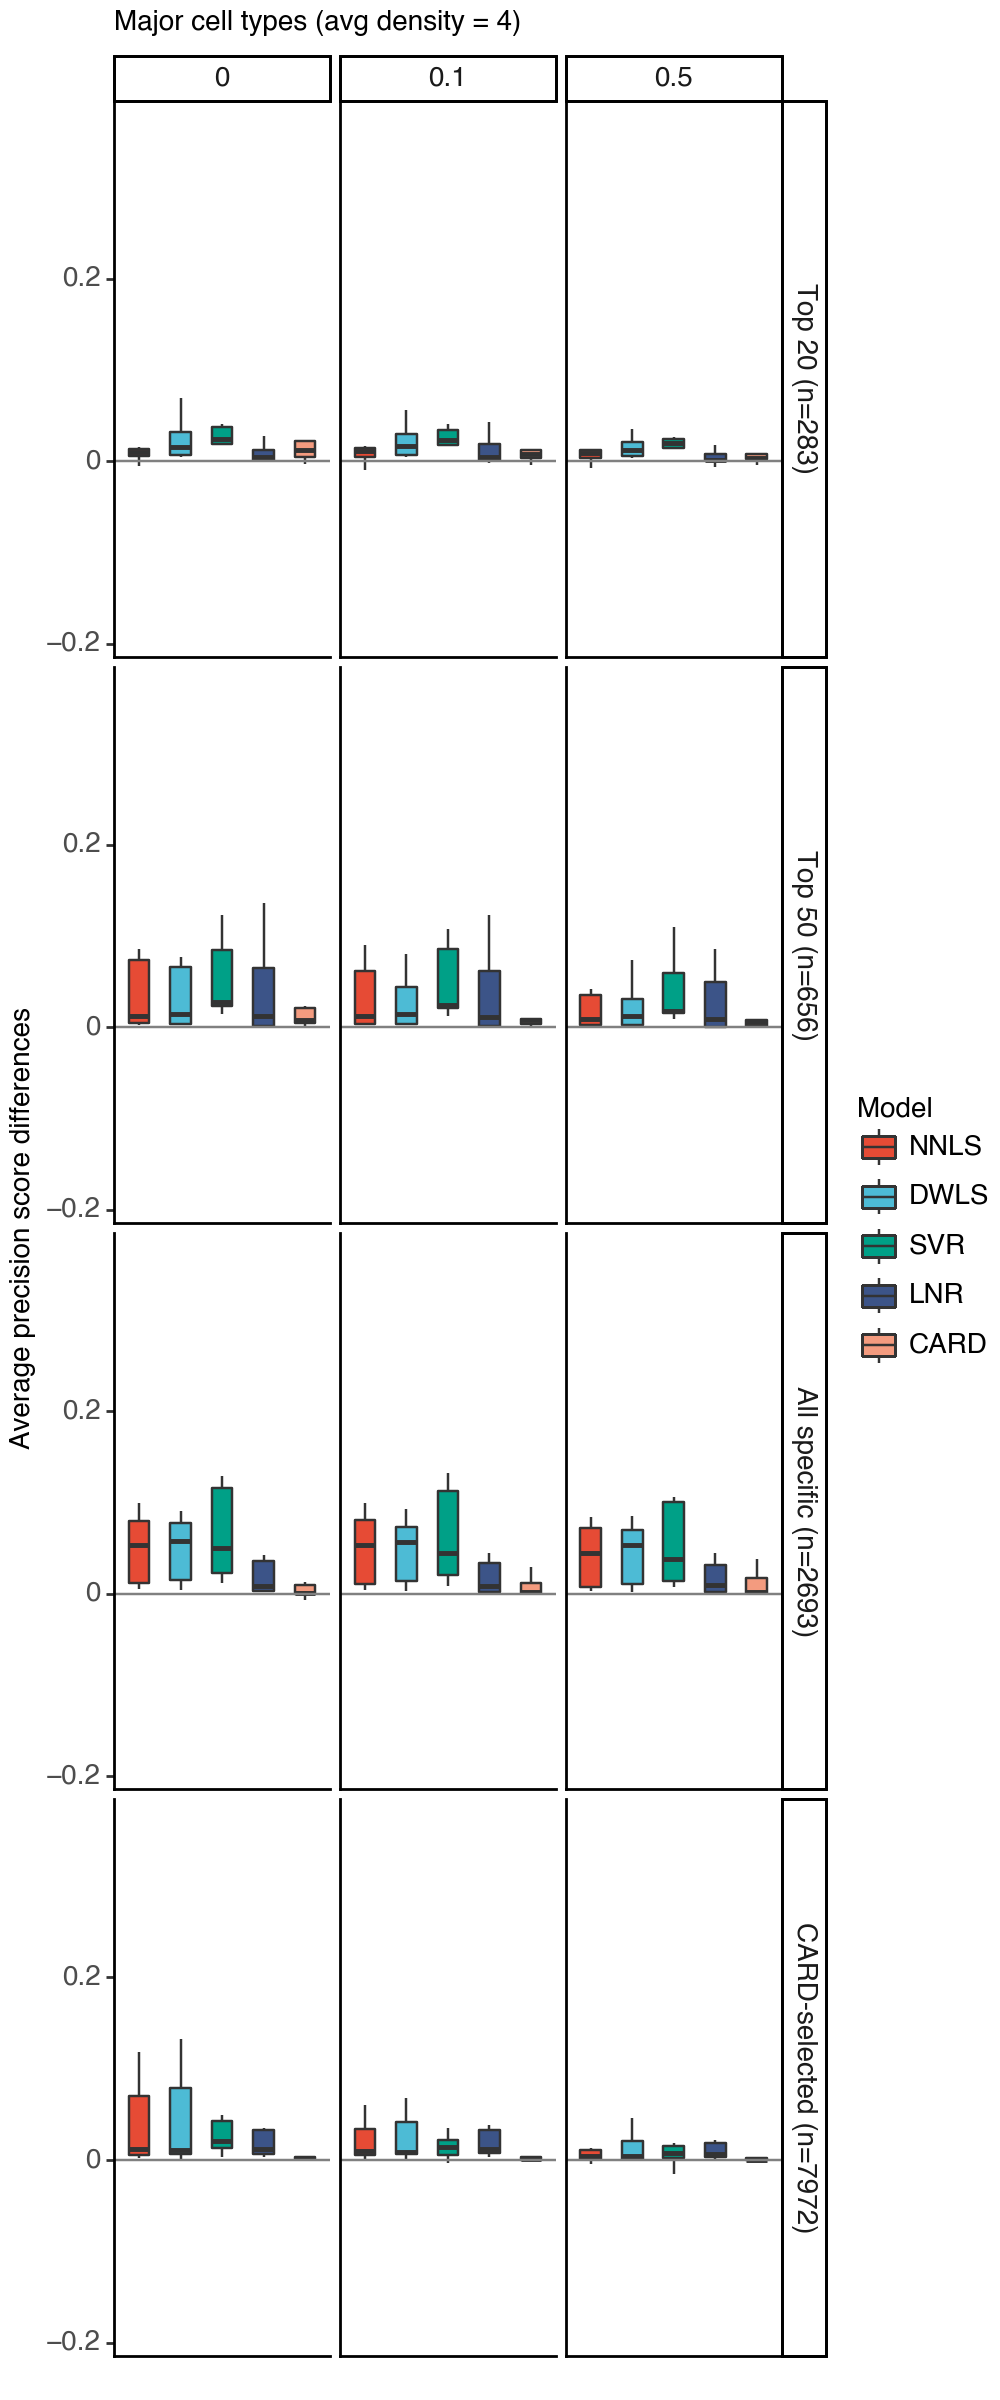

<Figure Size: (500 x 1200)>

In [18]:
(
    ggplot(df_diff_accu[df_diff_accu.is_high_density == 1], 
                aes(x='deconv_model', y = 'accu_diff', group = 'deconv_model')) +
    facet_grid('nm ~ sm', scales = 'fixed') +
    geom_boxplot(aes(fill = 'deconv_model'), width = 0.5, outlier_shape = '') +
    geom_hline(yintercept = 0, color = 'gray') +
    labs(x = '', y = 'Average precision score differences', fill = 'Model',
         title = 'Major cell types (avg density = 4)') +
    scale_fill_npg() +
    theme_classic() +
    scale_y_continuous() +
    theme(figure_size = (5, 12), 
          text = element_text(size=10),
             axis_text_x=element_blank(),
             axis_ticks_major_x=element_blank())
)


/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 110 rows containing non-finite values.


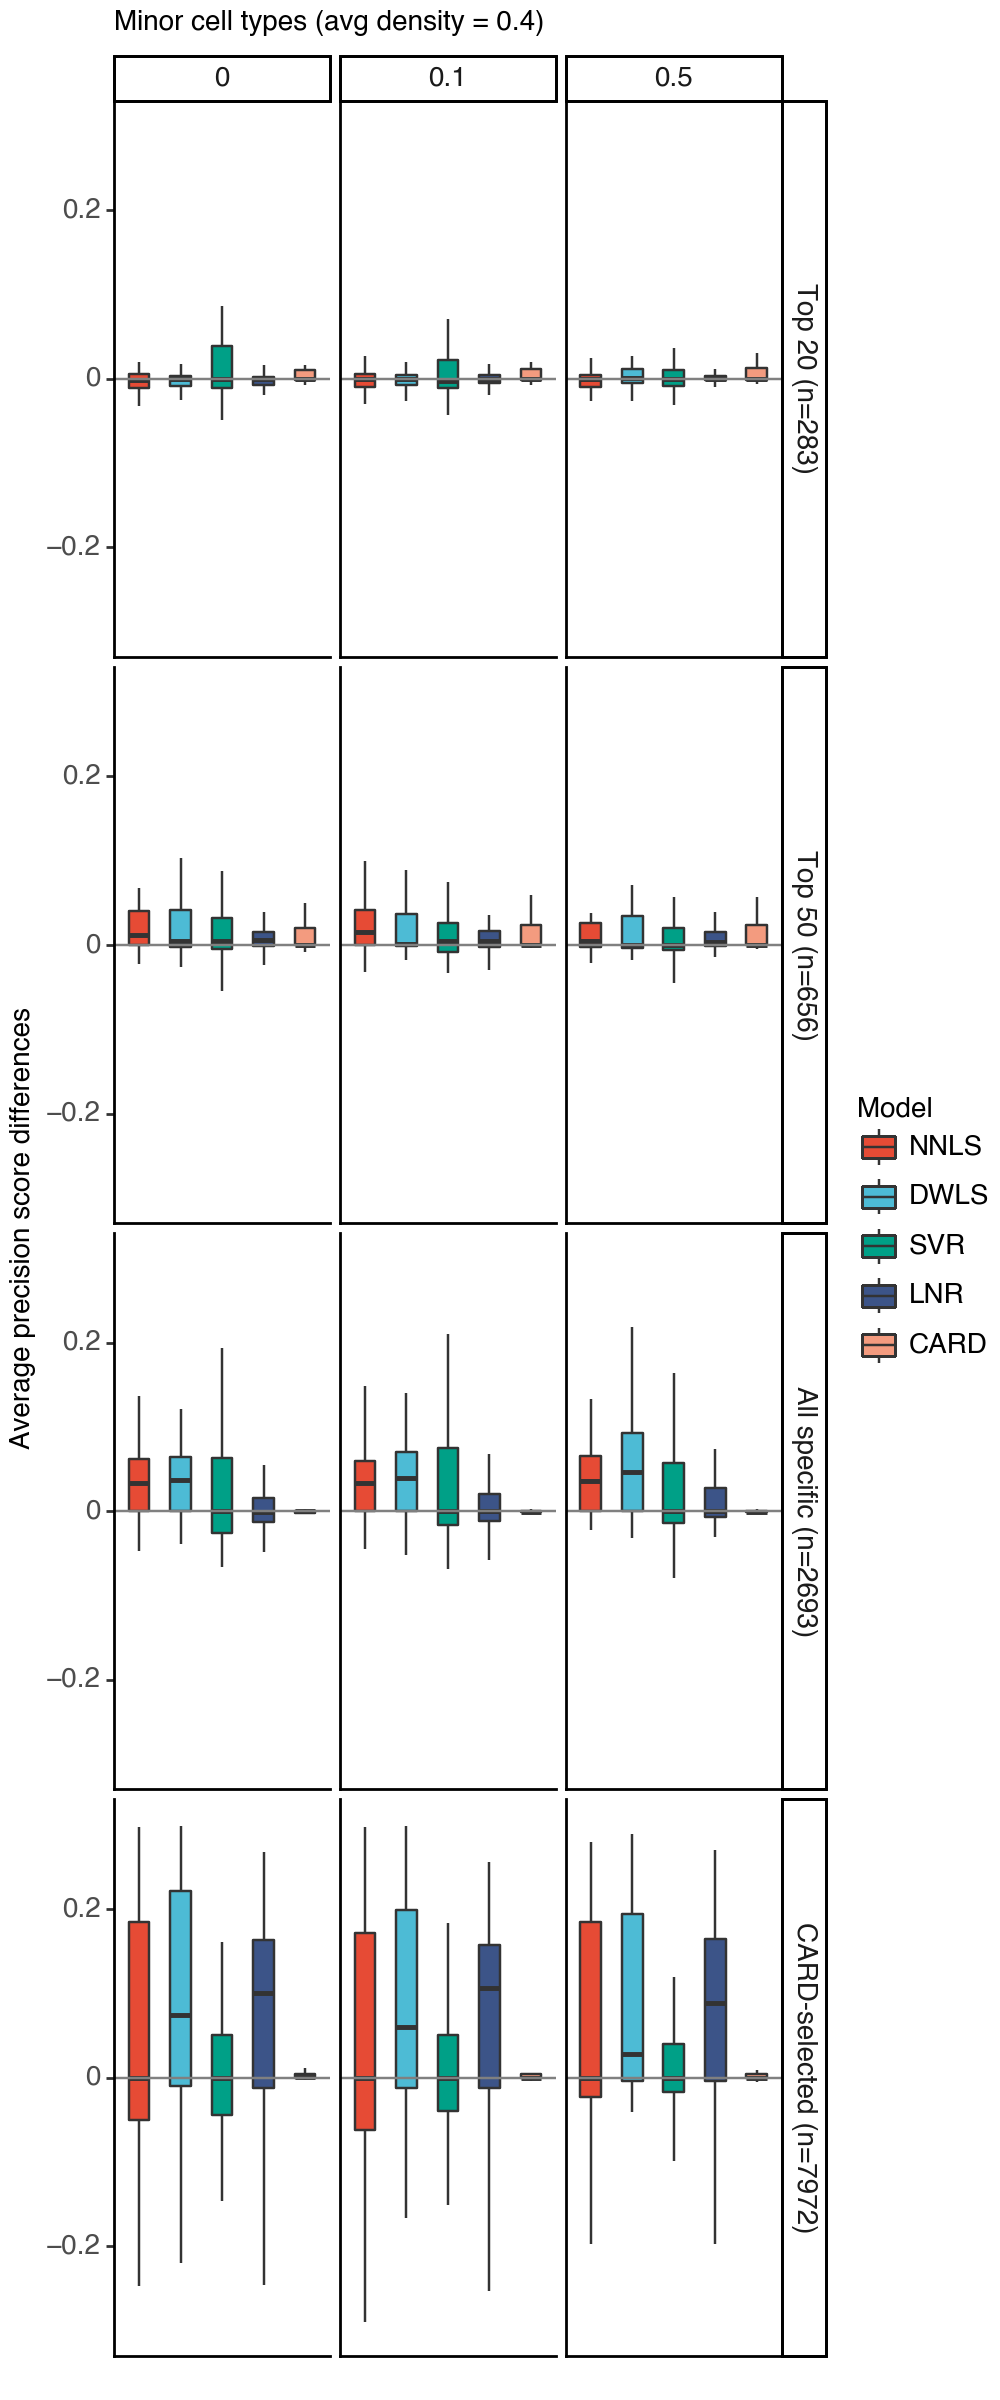

<Figure Size: (500 x 1200)>

In [19]:
(
    ggplot(df_diff_accu[df_diff_accu.is_high_density == 0], 
                aes(x='deconv_model', y = 'accu_diff', group = 'deconv_model')) +
    facet_grid('nm ~ sm', scales = 'fixed') +
    geom_boxplot(aes(fill = 'deconv_model'), width = 0.5, outlier_shape = '') +
    geom_hline(yintercept = 0, color = 'gray') +
    labs(x = '', y = 'Average precision score differences', fill = 'Model',
         title = 'Minor cell types (avg density = 0.4)') +
    theme_classic() +
    scale_fill_npg() +
    scale_y_continuous(limits = [-0.3,0.3]) +
    theme(figure_size = (5, 12), 
          text = element_text(size=10),
             axis_text_x=element_blank(),
             axis_ticks_major_x=element_blank())
)